In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["GEOMSTATS_BACKEND"] = 'jax'

import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from score_sde.utils import GlobalRNG

g_rng = GlobalRNG()

## Define an SDE class

In [2]:
from score_sde.sde import SDE, VPSDE, RSDE, ProbabilityFlowODE

INFO:root:Using jax backend


## Define rollout sampler for an SDE

In [3]:
from score_sde.sampling import get_pc_sampler

In [4]:
def plot_2dsde(x_hist):
    fig, axes = plt.subplots(1,3, sharey=False, figsize=(9,3))

    axes[0].set_aspect('equal', share=False)
    n = 4
    for i in range(n):
        i = int(i * x_hist.shape[1] / n)
        sns.kdeplot(x_hist[:,i,0], x_hist[:,i,1], ax=axes[0])
    sns.kdeplot(x_hist[:,-1,0], x_hist[:,-1,1], ax=axes[0])

    axes[1].plot(x_hist.mean(axis=0)[..., 0], label='x')
    axes[1].plot(x_hist.mean(axis=0)[..., 1], label='y')
    axes[1].legend()

    axes[2].plot(x_hist.std(axis=0)[..., 0], label='x')
    axes[2].plot(x_hist.std(axis=0)[..., 1], label='y')
    axes[2].legend()
    
    axes[0].set_title("KDE estimate")
    axes[1].set_title("Mean")
    axes[2].set_title("Std")

    plt.tight_layout()

    return fig, axes

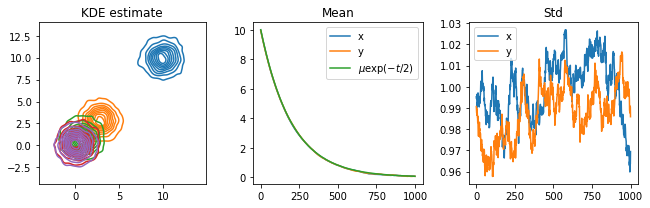

In [59]:
N=1000
forward_sde = VPSDE(10, beta_0=1, beta_f=1)
sampler = get_pc_sampler(forward_sde, N=N, predictor='EulerMaruyamaPredictor')

mean, var = 10, 1
x_init = mean + var * forward_sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

x_sample, x_hist = sampler(jax.random.PRNGKey(0), x_init)

fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(forward_sde.t0, forward_sde.tf,num=N, endpoint=True)
axes[1].plot(mean * jnp.exp(-0.5 * t_), label='$\mu \exp(-t/2)$')
axes[1].legend()
axes[2].legend()

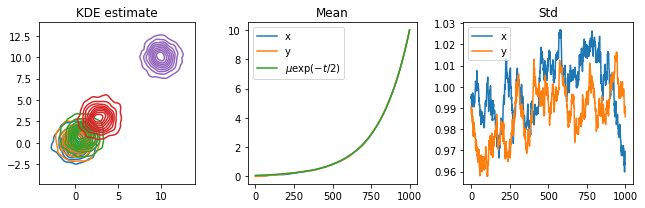

In [60]:
# This score function is ONLY accurate for beta(t) = 1
def score_fn(x, t):
    return -(x - mean * jnp.exp(-t[..., None]/2))

reverse_sde = RSDE(forward_sde, score_fn)
reverse_sampler = get_pc_sampler(reverse_sde, N=N, predictor='EulerMaruyamaPredictor')

x_init = reverse_sde.sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

x_sample, x_hist = reverse_sampler(jax.random.PRNGKey(0), x_init)

fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(reverse_sde.t0, reverse_sde.tf,num=N, endpoint=True)
axes[1].plot(mean * jnp.exp(-0.5 * t_), label='$\mu \exp(-t/2)$')
axes[1].legend()
axes[2].legend()


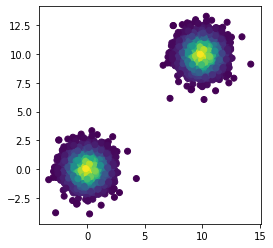

In [61]:
from score_sde.likelihood import get_likelihood_fn

likelihood_fn = get_likelihood_fn(forward_sde, score_fn, hutchinson_type='Gaussian', bits_per_dimension=False)
logl, z, N = likelihood_fn(next(g_rng), x)

plt.scatter(x[..., 0], x[..., 1], c = jnp.exp(logl))
plt.scatter(z[..., 0], z[..., 1], c = jnp.exp(forward_sde.limiting_distribution_logp(z)))
plt.gca().set_aspect('equal')